In [1]:
import pandas as pd
import psycopg2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#conectando ao banco de dados
conn = psycopg2.connect(dbname="dfo2vqe9hs2knm", 
                        user="zgbodaynfjorzt",
                        password="d2b11c0c6039df67f39d22f680fb92a843a1b652e3d5b692f6670c0a2abc2804", 
                        host='ec2-3-222-74-92.compute-1.amazonaws.com', 
                        port='5432')

In [3]:
sql1 = "select * from forms"
sql2 = "select * from order_items"
sql3 = "select * from orders"

In [4]:
data1 = pd.read_sql_query(sql1, conn)
data2 = pd.read_sql_query(sql2, conn)
data3 = pd.read_sql_query(sql3, conn)
conn = None

In [5]:
data1.head()

,id_form,id_cliente,data,sistema_operacional,navegador,localizacao,locale,cidade,estado,qtde_lavagem_semana,...,tipo_fios,procedimentos,tempo_procedimento,dieta,atividade_fisica,frequencia_estresse,caracteristica,faixa_etaria,efeitos_desejados,fragancia
0,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,4,...,Pontas duplas,Nenhum,Há 2 semanas,Celíaca,Frequente,Nunca,Característica 1,25 a 34,Efeito 7,Rosas
1,72830da153824af486be15cd48b3f3,9a48802d8290d19471f3,2022-01-04 08:39:53,Windows,Chrome,"Ribeirão Preto, Sao Paulo",BR,RIBEIRÃO PRETO,SAO PAULO,7,...,Perfeitos,Todos acima,Há mais de 1 mês,Nenhuma restrição,Nunca,Nunca,Característica 6,55 a 64,Efeito 1,Eucalipto
2,d101fc0075dac29db1168cfc61ad44,c3344fad450ee424700d,2022-01-04 19:34:05,Android,Chrome,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,2,...,Rebeldes,Todos acima,Há mais de 1 mês,Nenhuma restrição,Raramente,Regularmente,Característica 7,2 a 10,Efeito 7,Rosas
3,0957fb9d7be36b4d079b6582bb6785,8105e34124e90300d8b5,2022-01-05 18:29:41,Android,Chrome,"Manchester, England",BR,MANCHESTER,ENGLAND,5,...,Rebeldes,Todos acima,Há mais de 1 mês,Celíaca,Raramente,Regularmente,Característica 7,25 a 34,Efeito 7,Rosas
4,ba73bdcc6c063ab08b533eae5505eb,636382f3f545eec3fe97,2022-01-07 11:44:31,Android,Chrome,"Tijucas, Santa Catarina",BR,TIJUCAS,SANTA CATARINA,4,...,Rebeldes,Tintura,Há 1 semana,Celíaca,Sempre,Nunca,Característica 10,18 a 24,Efeito 7,Eucalipto


In [6]:
#limpeza dos dados
data1.drop(['localizacao','navegador','utm_source'], axis = 1, inplace = True)

In [7]:
data1['cidade'] = data1['cidade'].replace(np.NaN, 0)

In [8]:
cidade_0  = data1[data1.cidade == 0]


In [9]:
data1['estado'] = data1['estado'].replace(' NULL', 0)

In [10]:
estado_0 = data1[data1.estado == 0]


In [11]:
data1 = data1.drop(index = estado_0.index)

In [12]:
data1['estado'] = data1['estado'].replace(np.NaN, 0)
estado_0 = data1[data1.estado == 0]

In [13]:
data1 = data1.drop(index = estado_0.index)

In [14]:
data1.drop(['locale'], axis = 1, inplace = True)

In [15]:
#criando uma coluna de dia da semana
data1['dia_semana'] = data1['data'].dt.day_name()

In [16]:
#agrupando os estados fora do brasil + Amapa
df_tipo_estado = data1.estado.value_counts()
colunas_agrupar = []

for tipo in df_tipo_estado.index:
    if df_tipo_estado[tipo] < 400:
        colunas_agrupar.append(tipo)

In [17]:
#dos estados brasileiro, somente Roraima entrou como outros
for tipo in colunas_agrupar:
    data1.loc[data1['estado']==tipo, 'estado'] = 'Outros'

In [18]:
#apagando os dados nulos de efeitos_desejados
data1.dropna(subset = ['efeitos_desejados'], inplace = True)

In [19]:
#avaliar a quantidade de efeitos_desejados
data1['num_efeitos_desejados'] = data1.efeitos_desejados.str.split(',').apply(len)

In [20]:
# repetindo o processo para numero_caracteristica e numero_procedimentos
data1['num_caracteristica'] = data1.caracteristica.str.split(',').apply(len)
data1['num_procedimentos'] = data1.procedimentos.str.split(',').apply(len)

In [21]:
#apagando as colunas 'efeitos_desejados','caracteristica','procedimentos'
data1 = data1.drop(['efeitos_desejados','caracteristica','procedimentos'], axis = 1)

### Combinando os DF

In [22]:
#criando uma coluna target no DF de fechamento das compras
data3['target'] = 1

In [23]:
#preparando o data2 - criar um data4 para fazer a combinação
data4 = data2.drop(['id','id_produto','qtde','valor'], axis = 1)

In [24]:
#id_pedido
#data 3 left - parâmetro inner, on id_pedido, 
data5 = pd.merge(
    left = data3,
    right = data4,
    on = 'id_pedido',    
)

In [25]:
data6 = data5[['id_form', 'target']]

In [26]:
data7 = pd.merge(
    left = data1,
    right = data6,
    how = 'left',
    on = 'id_form'
    
)

In [27]:
data7['target'] = data7['target'].replace(np.NaN, 0)

In [28]:
dados = data7.drop(['id_form', 'id_cliente', 'data', 'cidade'], axis = 1)

### Analytics dos dados

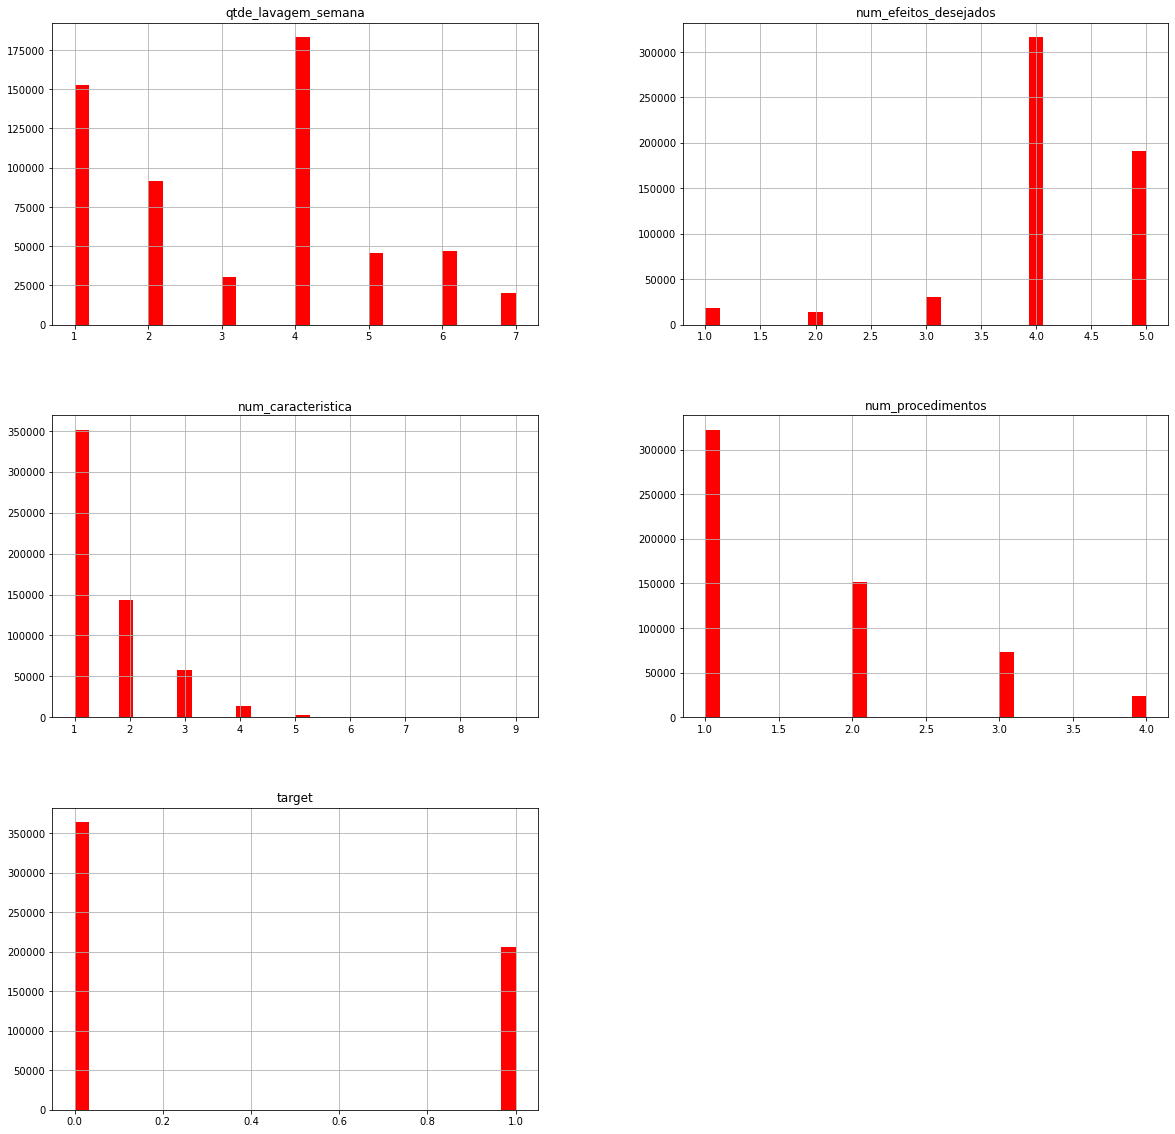

In [29]:
#distribuição dos dados
dados.hist(bins = 30, figsize=(20,20), color = 'r');

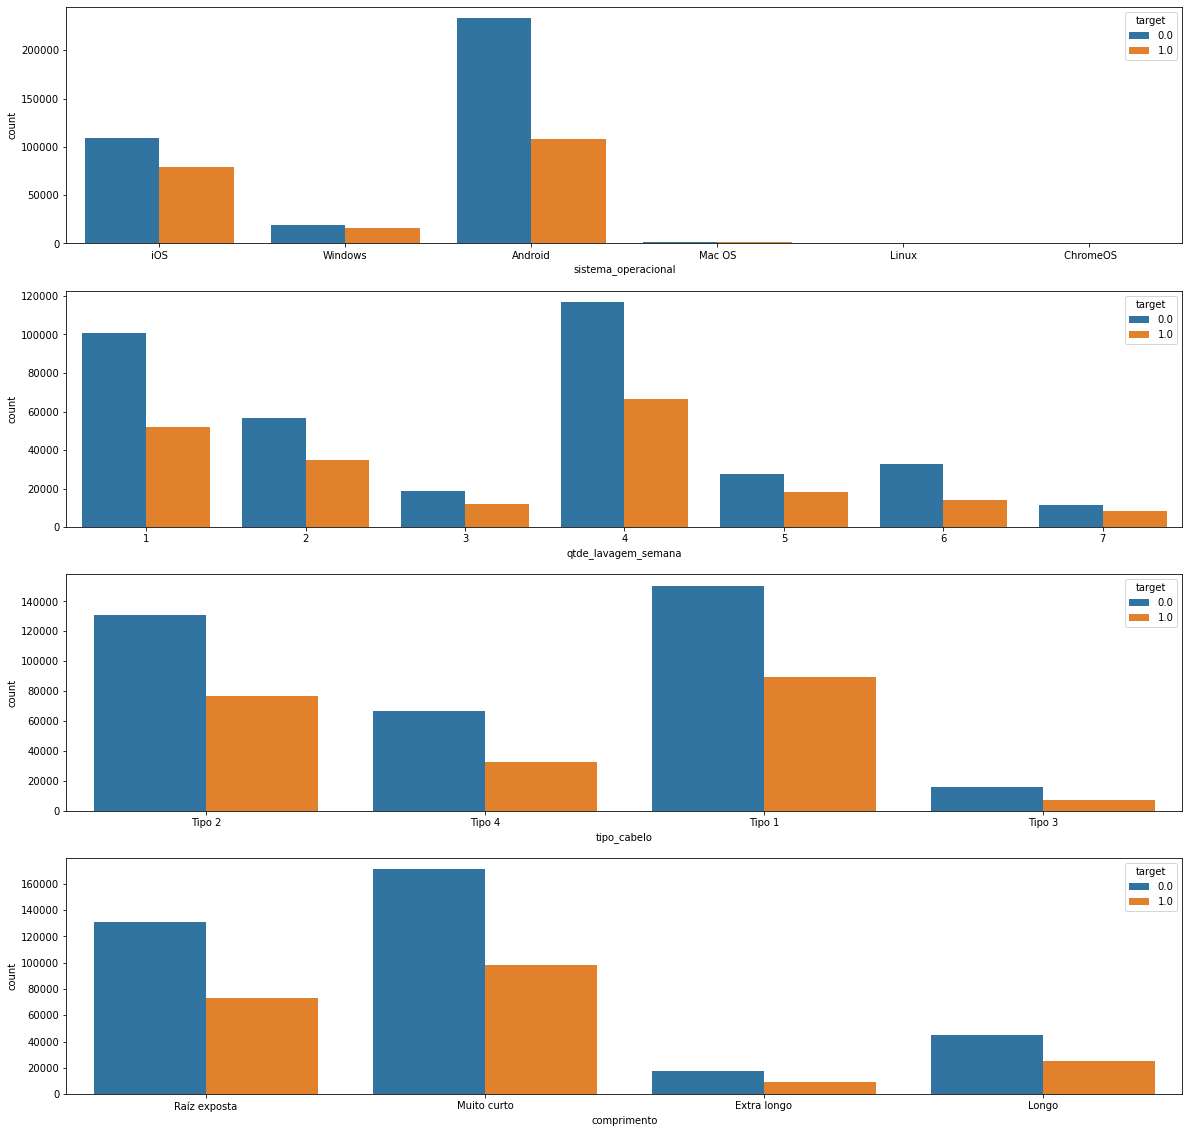

In [30]:
#análise do perfil de quem compra e quem não compra
plt.figure(figsize=[20,20])
plt.subplot(411)
sns.countplot(x = 'sistema_operacional', hue = 'target', data=dados)
plt.subplot(412)
sns.countplot(x = 'qtde_lavagem_semana', hue = 'target', data=dados)
plt.subplot(413)
sns.countplot(x = 'tipo_cabelo', hue = 'target', data=dados)
plt.subplot(414)
sns.countplot(x = 'comprimento', hue = 'target', data=dados);

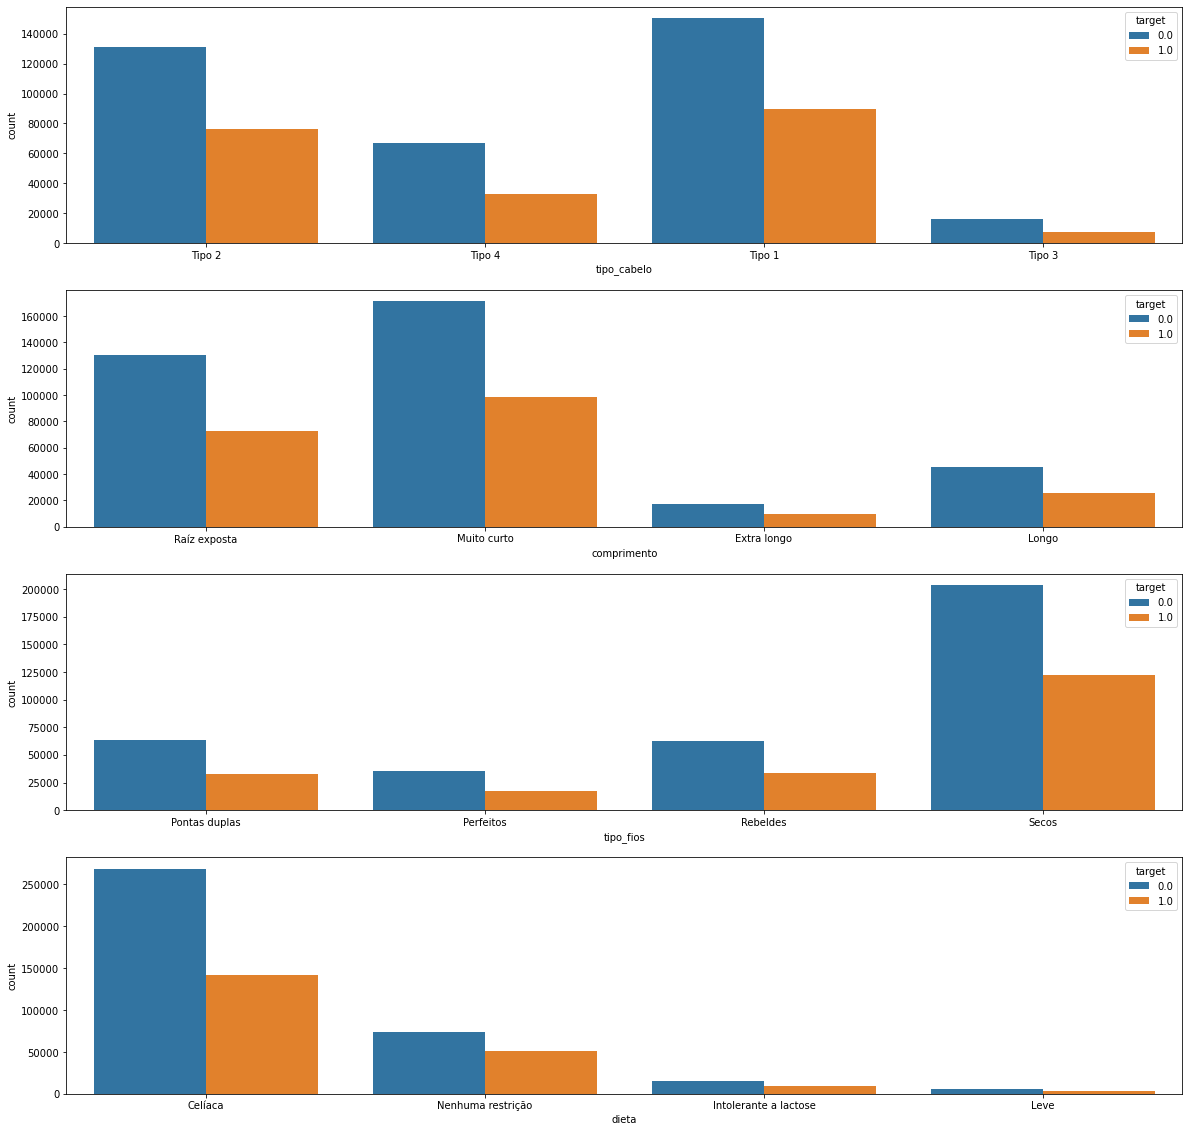

In [31]:
plt.figure(figsize=[20,20])
plt.subplot(411)
sns.countplot(x = 'tipo_cabelo', hue = 'target', data=dados)
plt.subplot(412)
sns.countplot(x = 'comprimento', hue = 'target', data=dados)
plt.subplot(413)
sns.countplot(x = 'tipo_fios', hue = 'target', data=dados)
plt.subplot(414)
sns.countplot(x = 'dieta', hue = 'target', data=dados);

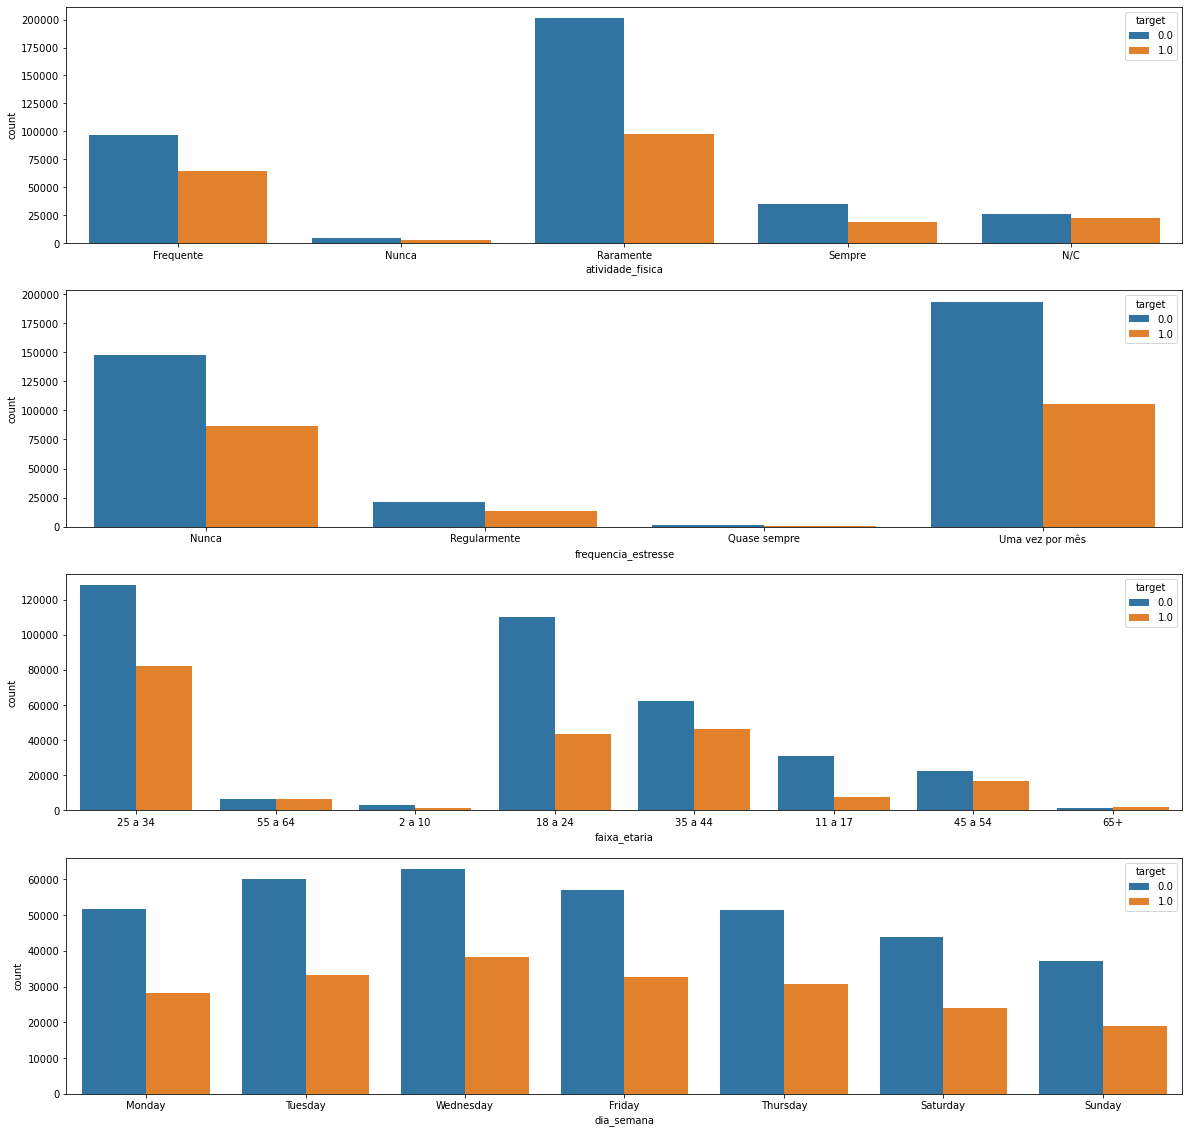

In [32]:
plt.figure(figsize=[20,20])
plt.subplot(411)
sns.countplot(x = 'atividade_fisica', hue = 'target', data=dados)
plt.subplot(412)
sns.countplot(x = 'frequencia_estresse', hue = 'target', data=dados)
plt.subplot(413)
sns.countplot(x = 'faixa_etaria', hue = 'target', data=dados)
plt.subplot(414)
sns.countplot(x = 'dia_semana', hue = 'target', data=dados);

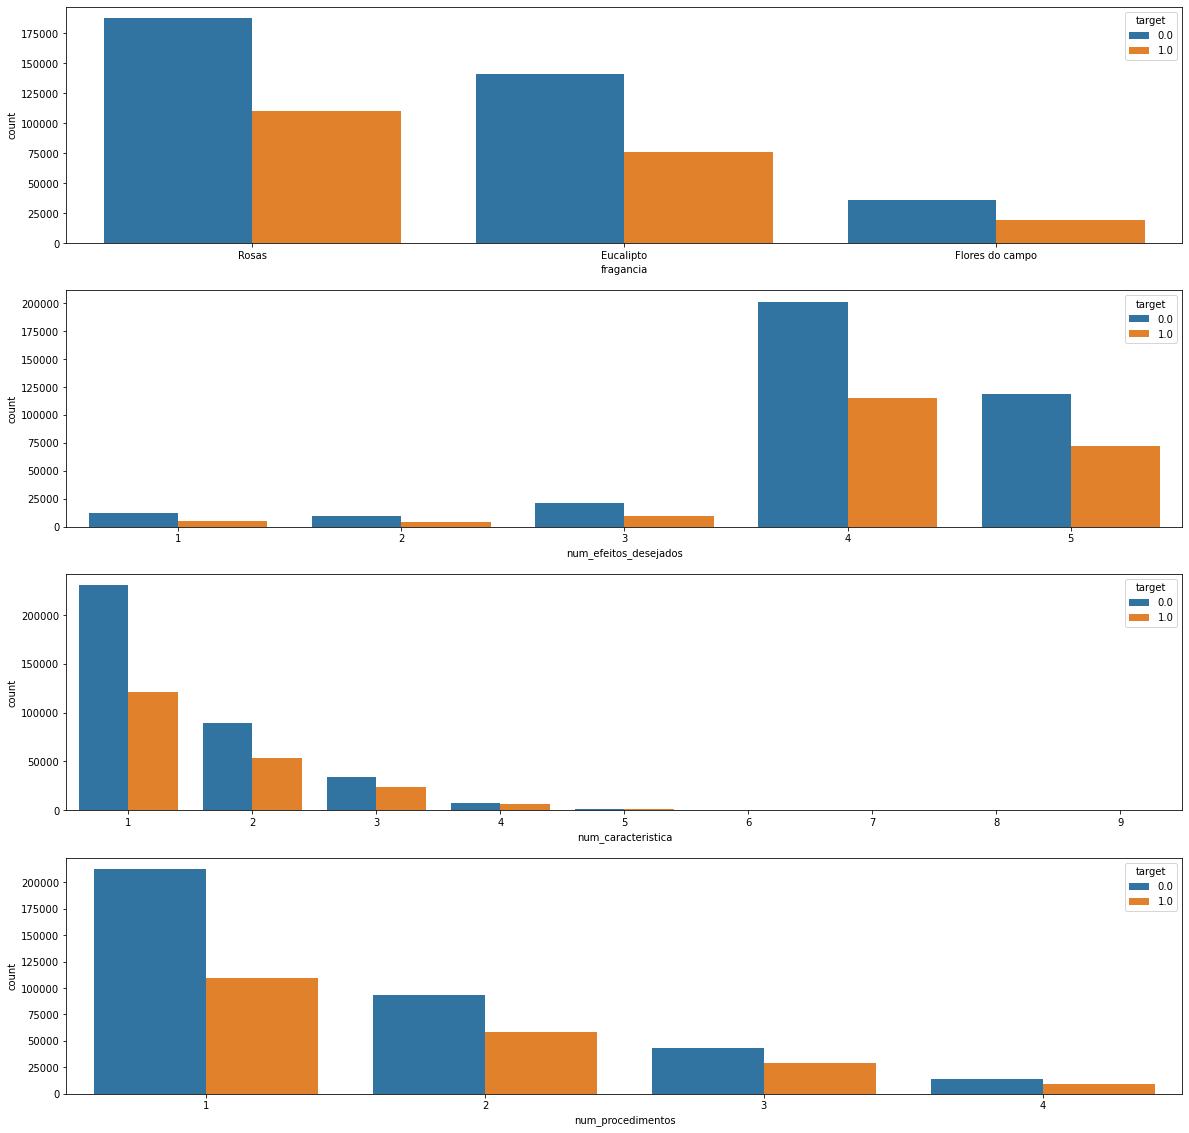

In [33]:
plt.figure(figsize=[20,20])
plt.subplot(411)
sns.countplot(x = 'fragancia', hue = 'target', data=dados)
plt.subplot(412)
sns.countplot(x = 'num_efeitos_desejados', hue = 'target', data=dados)
plt.subplot(413)
sns.countplot(x = 'num_caracteristica', hue = 'target', data=dados)
plt.subplot(414)
sns.countplot(x = 'num_procedimentos', hue = 'target', data=dados);